In [52]:
import pandas as pd
import seaborn as sns
from surprise import Dataset
from surprise import Reader
from surprise import SVD
from surprise.prediction_algorithms import knns
from surprise.model_selection import train_test_split, KFold, GridSearchCV
from surprise.similarities import cosine, msd, pearson
from surprise import accuracy

## Intro to problem

### Load Data

In [2]:
books = pd.read_csv('books.csv')
books.head()

,book_id,goodreads_book_id,best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
0,1,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,2,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...
2,3,41865,41865,3212258,226,316015849,9.780316e+12,Stephenie Meyer,2005.0,Twilight,...,3866839,3916824,95009,456191,436802,793319,875073,1355439,https://images.gr-assets.com/books/1361039443m...,https://images.gr-assets.com/books/1361039443s...
3,4,2657,2657,3275794,487,61120081,9.780061e+12,Harper Lee,1960.0,To Kill a Mockingbird,...,3198671,3340896,72586,60427,117415,446835,1001952,1714267,https://images.gr-assets.com/books/1361975680m...,https://images.gr-assets.com/books/1361975680s...
4,5,4671,4671,245494,1356,743273567,9.780743e+12,F. Scott Fitzgerald,1925.0,The Great Gatsby,...,2683664,2773745,51992,86236,197621,606158,936012,947718,https://images.gr-assets.com/books/1490528560m...,https://images.gr-assets.com/books/1490528560s...


In [3]:
books.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
book_id                      10000 non-null int64
goodreads_book_id            10000 non-null int64
best_book_id                 10000 non-null int64
work_id                      10000 non-null int64
books_count                  10000 non-null int64
isbn                         9300 non-null object
isbn13                       9415 non-null float64
authors                      10000 non-null object
original_publication_year    9979 non-null float64
original_title               9415 non-null object
title                        10000 non-null object
language_code                8916 non-null object
average_rating               10000 non-null float64
ratings_count                10000 non-null int64
work_ratings_count           10000 non-null int64
work_text_reviews_count      10000 non-null int64
ratings_1                    10000 non-null int64
ratings_2                    10000 n

In [4]:
ratings = pd.read_csv('ratings.csv')
ratings.head()

,user_id,book_id,rating
0,1,258,5
1,2,4081,4
2,2,260,5
3,2,9296,5
4,2,2318,3


In [5]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5976479 entries, 0 to 5976478
Data columns (total 3 columns):
user_id    int64
book_id    int64
rating     int64
dtypes: int64(3)
memory usage: 136.8 MB


## EDA

**write a bit about it**

In [32]:
print(f'Number of unique users: {ratings.user_id.nunique()}')
print(f'Number of unique items(books): {ratings.book_id.nunique()}')

Number of unique users: 53424
Number of unique items(books): 10000


We have almost 6 million ratings by over 53 thousand unique users for 10,000 books.

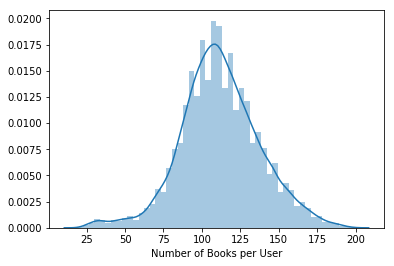

In [7]:
sns.distplot(ratings.user_id.value_counts(), axlabel='Number of Books per User');

In [8]:
print(f'The mean number of books rated by user is {ratings.user_id.value_counts().mean()}')
print(f'The median number of books rated by user is {ratings.user_id.value_counts().median()}')

The mean number of books rated by user is 111.86880428271938
The median number of books rated by user is 111.0


In [19]:
count = ratings.rating.value_counts()
count.index

Int64Index([4, 5, 3, 2, 1], dtype='int64')

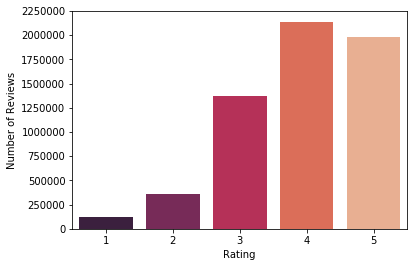

In [55]:
ax = sns.barplot(x=count.index, y=count, palette='rocket')
ax.set_ylabel('Number of Reviews')  
ax.set_xlabel('Rating'); 

## Modeling

### Memory-based Collaboration Filtering with surprise library

Let's start with a simple tecnique. We will apply a memory-based collaboration filtering model using surprise library. We need to load the dataset into the right format in order to use it with surprise library.

In [39]:
# define reader
reader = Reader(rating_scale=(1, 5))

# load dataframe into correct format for surprise library
data = Dataset.load_from_df(ratings[['user_id', 'book_id', 'rating']], reader)

In [40]:
# check it's the right data type
type(data)

surprise.dataset.DatasetAutoFolds

In [43]:
# check size of test set and have a look at one sample
print(len(testset))
print(testset[0])

1195296
(11300, 7583, 5.0)


In [42]:
# Split into train and test set
trainset, testset = train_test_split(data, test_size=0.2)

In [46]:
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items, '\n')

Number of users:  53424 

Number of items:  10000 



Because we have more users than books we will start simple and calculate item-item similarity. Let's try different similarity metrics and see which performs better.

In [33]:
sim_cos = {'name':'cosine', 'user_based':False}

In [56]:
basic = knns.KNNBasic(sim_options=sim_cos)
basic.fit(trainset)

Computing the cosine similarity matrix...
Done computing similarity matrix.


In [57]:
predictions = basic.test(testset)

In [58]:
print(accuracy.rmse(predictions))

RMSE: 0.8852
0.8851663150972353


In [59]:
sim_pearson = {'name':'pearson', 'user_based':False}
basic_pearson = knns.KNNBasic(sim_options=sim_pearson)
basic_pearson.fit(trainset)
predictions = basic_pearson.test(testset)
print(accuracy.rmse(predictions))

Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8782
0.8781655835594508


In [60]:
sim_pearson = {'name':'pearson', 'user_based':False}
knn_baseline = knns.KNNBaseline(sim_options=sim_pearson)
knn_baseline.fit(trainset)
predictions = knn_baseline.test(testset)
print(accuracy.rmse(predictions))

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
RMSE: 0.8418
0.8417557761945417


In [51]:
# define a cross-validation iterator
kf = KFold(n_splits=3)

algo = SVD()

for trainset, testset in kf.split(data):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.8411
RMSE: 0.8415
RMSE: 0.8414


In [ ]:
param_grid = {'n_factors':[20, 100],'n_epochs': [5, 10], 'lr_all': [0.002, 0.005],
              'reg_all': [0.4, 0.6]}
gs_model = GridSearchCV(SVD,param_grid=param_grid,n_jobs = -1,joblib_verbose=5)
gs_model.fit(data)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
